In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_path = "../../Data_Practical_2" 
TRAIN_CSV = base_path + "/training_set_pixel_size_and_HC.csv"
TRAIN_IMG_DIR = base_path + "/training_set"

TEST_CSV = base_path + "/test_set_pixel_size.csv"
TEST_IMG_DIR = base_path + "/test_set"

BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 30       
PATIENCE = 5        
best_val_loss = float('inf')
patience_counter = 0   

In [2]:
df = pd.read_csv(TRAIN_CSV)

display(df.head())

print(f"Total images: {len(df)}")

,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


Total images: 999


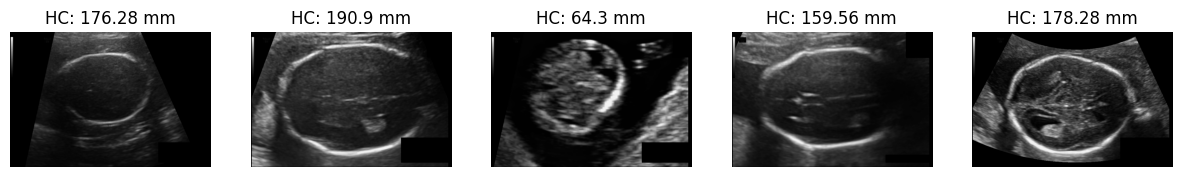

In [3]:
# 5 random images
sample_df = df.sample(5)

plt.figure(figsize=(15, 5))

for i, (index, row) in enumerate(sample_df.iterrows()):
    filename = row['filename']
    hc_value = row['head circumference (mm)']
    
    full_path = TRAIN_IMG_DIR + "/" + filename
    
    img = cv2.imread(full_path)
    
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"HC: {hc_value} mm")
        plt.axis('off')
    else:
        print(f"Could not load: {filename}")

plt.show()

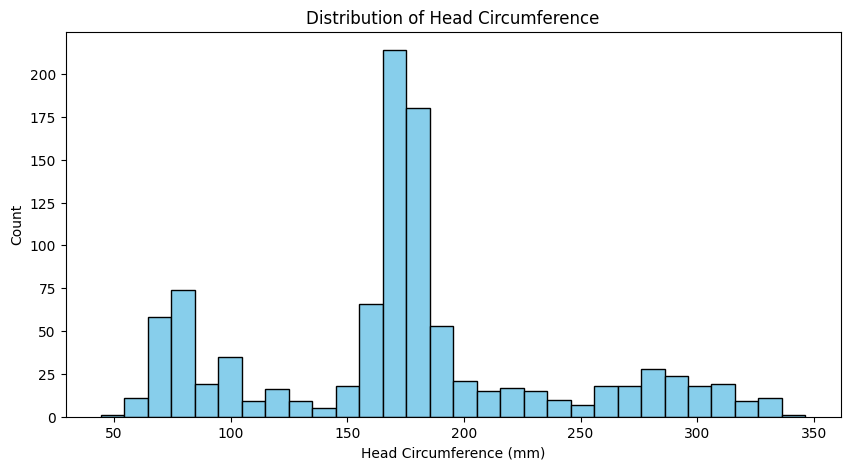

Min HC: 44.3
Max HC: 346.4


In [6]:
# Plot histogram of Head Circumference
plt.figure(figsize=(10, 5))
plt.hist(df['head circumference (mm)'], bins=30, color='skyblue', edgecolor='black')

plt.title('Distribution of Head Circumference')
plt.xlabel('Head Circumference (mm)')
plt.ylabel('Count')
plt.show()

print("Min HC:", df['head circumference (mm)'].min())
print("Max HC:", df['head circumference (mm)'].max())

### Model

In [ ]:
class HC18Dataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['filename']
        
        # Target: Head Circumference (mm)
        target = float(row['head circumference (mm)'])
        pixel_size = float(row['pixel size(mm)'])
        
        img_path = os.path.join(self.root_dir, img_name)
        
        image = Image.open(img_path).convert('RGB')
 
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(target, dtype=torch.float32), pixel_size, img_name
    

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),     
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),     
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Total images: {len(df)}")
print(f"Training set: {len(train_df)} images")
print(f"Validation set (for MAE): {len(val_df)} images")

train_ds = HC18Dataset(train_df, TRAIN_IMG_DIR, transform=train_transforms)
val_ds = HC18Dataset(val_df, TRAIN_IMG_DIR, transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_df)} | Val samples: {len(val_df)}")

Total images: 999
Training set: 799 images
Validation set (for MAE): 200 images
Train samples: 799 | Val samples: 200


In [ ]:
def build_model():
    model = models.resnet18(pretrained=True)
    
    model.fc = nn.Linear(model.fc.in_features, 1)
    
    return model.to(DEVICE)

model = build_model()
criterion = nn.L1Loss() # MAE Loss
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=2
)


In [ ]:
history = {'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    # Train
    model.train()
    running_train_loss = 0.0
    
    for images, targets, _, _ in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * images.size(0)
        
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    
    # Validate
    model.eval()
    running_val_loss = 0.0
    
    with torch.no_grad():
        for images, targets, _, _ in val_loader:
            images, targets = images.to(DEVICE), targets.to(DEVICE).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * images.size(0)
            
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    
    print(f"Epoch {epoch+1:02d} | Train MAE: {epoch_train_loss:.2f} | Val MAE: {epoch_val_loss:.2f}", end="")
    
    # Early Stopping & Checkpoint
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_Adam031.pth')
        print(f" Saved Best")
    else:
        patience_counter += 1
        print(f" Patience {patience_counter}/{PATIENCE}")
        
    if patience_counter >= PATIENCE:
        print(f"\n Early Stopping! Best Val MAE: {best_val_loss:.4f} mm")
        break


 FINAL VALIDATION RESULT:
  Mean Absolute Error (MAE): 10.97 mm


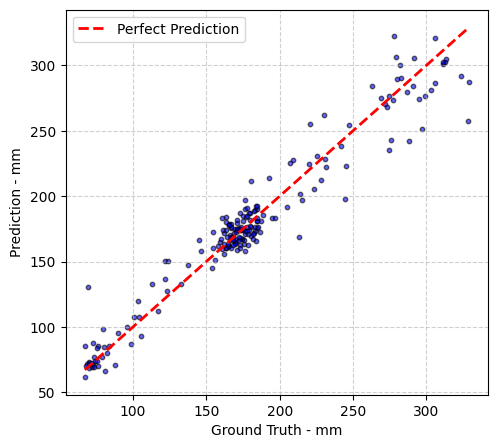

In [ ]:
model.load_state_dict(torch.load('best_model_SGD.pth'))
model.eval() 
all_preds = []
all_targets = []

with torch.no_grad(): 
    for images, targets, _, _ in val_loader:
        images = images.to(DEVICE)
        
        outputs = model(images)
        
        all_preds.extend(outputs.cpu().numpy().flatten())
        all_targets.extend(targets.numpy().flatten())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

final_mae = np.mean(np.abs(all_preds - all_targets))

print(f" FINAL VALIDATION RESULT:")
print(f"  Mean Absolute Error (MAE): {final_mae:.2f} mm")

# Scatter plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(all_targets, all_preds, alpha=0.6, c='blue', edgecolors='k', s=10)
plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Ground Truth - mm')
plt.ylabel('Prediction - mm')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

